<h1 style="text-align: center;">DATA 255 - Fall24 - Group Project</h1>

<h2 style="text-align: center;"> Pneumonia Detection using chest X-Ray and Deep Learning Technologies

## 1. Importing necessary libraries

In [ ]:
#pip install torchinfo

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchinfo import summary
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import shutil
import random
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc

## 2. Loading and Exploring the data

#### <b> 2.1. Creating a DataFrame containing file paths and corresponding labels for images in a dataset

In [ ]:
def create_dataset(folder_path):
    file_path_label_list = []
    # Iterating over the two classes
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(folder_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensuring we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path_label_list.append([file_path, category])
    return pd.DataFrame(file_path_label_list, columns=['file_path', 'label'])

#### <b> 2.2. Setting Up Dataset Paths

In [ ]:
from google.colab import drive
# Mounting Google Drive for reading and writing data
drive.mount('/content/drive')

# Raw dataset paths
dataset_dir = '/content/drive/My Drive/MSDA Sem 3/Deep Learning/Project/chest_xray'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

Mounted at /content/drive


#### <b> 2.3. Creating DataFrames for Train, Validation, and Test Datasets

In [ ]:
# Creating DataFrames for train, validation, and test datasets
train_df = create_dataset(train_dir)
val_df = create_dataset(val_dir)
test_df = create_dataset(test_dir)

#### <b> 2.4. Converting Labels to Numeric Values

In [ ]:
# Converting labels to numeric: NORMAL -> 0, PNEUMONIA -> 1
train_df['label'] = train_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
val_df['label'] = val_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
test_df['label'] = test_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

# Print dataset sizes
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}, Test set size: {len(test_df)}")

Train set size: 5216, Validation set size: 16, Test set size: 624


#### <b> 2.5. Count Categories for All Datasets

In [ ]:
# Function to count categories in a given DataFrame
def count_categories(df, dataset_name):
    category_counts = df['label'].value_counts()
    print(f"{dataset_name} set:")
    print(f"  NORMAL: {category_counts.get(0, 0)}")
    print(f"  PNEUMONIA: {category_counts.get(1, 0)}")

# Count and display for train, validation, and test datasets
print("Image Counts per Category:")
count_categories(train_df, "Train")
count_categories(val_df, "Validation")
count_categories(test_df, "Test")

Image Counts per Category:
Train set:
  NORMAL: 1341
  PNEUMONIA: 3875
Validation set:
  NORMAL: 8
  PNEUMONIA: 8
Test set:
  NORMAL: 234
  PNEUMONIA: 390


## 3. Data redistribution and EDA
- Data redistribution is bring done since the train, validation and test data counts are not balanced
- Redistribution to be done only once to ensure random splits happens only once

#### <b> 3.1. Redistributing Data

In [ ]:
'''
# New directories for redistributed data
redis_dir_base = os.path.join(dataset_dir, 'chest_xray_redistributed')
train_new_dir = os.path.join(redis_dir_base, 'train')
val_new_dir = os.path.join(redis_dir_base, 'val')
test_new_dir = os.path.join(redis_dir_base, 'test')

# Creating new directories
os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_new_dir, exist_ok=True)
os.makedirs(test_new_dir, exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
    os.makedirs(os.path.join(train_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_new_dir, cls), exist_ok=True)

# Function to gather all images in a directory structure
def get_all_images(directory, class_name):
    full_path = os.path.join(directory, class_name)
    return [os.path.join(full_path, fname) for fname in os.listdir(full_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Gather images from the original directories
all_normal = get_all_images(train_dir, 'NORMAL') + get_all_images(val_dir, 'NORMAL') + get_all_images(test_dir, 'NORMAL')
all_pneumonia = get_all_images(train_dir, 'PNEUMONIA') + get_all_images(val_dir, 'PNEUMONIA') + get_all_images(test_dir, 'PNEUMONIA')

# Shuffle images for random distribution
random.shuffle(all_normal)
random.shuffle(all_pneumonia)

# Function to split data into train, validation, and test sets
def split_data(data, train_ratio, val_ratio):
    train_split = int(len(data) * train_ratio)
    val_split = int(len(data) * (train_ratio + val_ratio))
    return data[:train_split], data[train_split:val_split], data[val_split:]

# Split the data
train_normal, val_normal, test_normal = split_data(all_normal, 0.7, 0.15)
train_pneumonia, val_pneumonia, test_pneumonia = split_data(all_pneumonia, 0.7, 0.15)

# Function to copy files to target directory
def copy_files(file_list, target_dir):
    for file_path in file_list:
        shutil.copy(file_path, target_dir)

# Copy files to new directories
copy_files(train_normal, os.path.join(train_new_dir, 'NORMAL'))
copy_files(val_normal, os.path.join(val_new_dir, 'NORMAL'))
copy_files(test_normal, os.path.join(test_new_dir, 'NORMAL'))

copy_files(train_pneumonia, os.path.join(train_new_dir, 'PNEUMONIA'))
copy_files(val_pneumonia, os.path.join(val_new_dir, 'PNEUMONIA'))
copy_files(test_pneumonia, os.path.join(test_new_dir, 'PNEUMONIA'))

print("Data redistribution complete!")
'''

Data redistribution complete!


#### <b> 3.2. Counting Images in Redistributed Datasets

In [ ]:
# New directories for redistributed data
redis_dir_base = os.path.join(dataset_dir, 'chest_xray_redistributed')
train_new_dir = os.path.join(redis_dir_base, 'train')
val_new_dir = os.path.join(redis_dir_base, 'val')
test_new_dir = os.path.join(redis_dir_base, 'test')

# Function to count images per class
def count_images_per_class(directory):
    dataset = datasets.ImageFolder(directory)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts


# Counting images in redistributed datasets
redistributed_train_counts = count_images_per_class(train_new_dir)
redistributed_val_counts = count_images_per_class(val_new_dir)
redistributed_test_counts = count_images_per_class(test_new_dir)

# Total images in redistributed datasets
total_images_redistributed = (
    sum(redistributed_train_counts.values()) +
    sum(redistributed_val_counts.values()) +
    sum(redistributed_test_counts.values())
)

# Calculating ratios
train_ratio_redistributed = sum(redistributed_train_counts.values()) / total_images_redistributed * 100
val_ratio_redistributed = sum(redistributed_val_counts.values()) / total_images_redistributed * 100
test_ratio_redistributed = sum(redistributed_test_counts.values()) / total_images_redistributed * 100

# Printing ratios
print("Redistributed Data Ratios:")
print(f"Training Set: {sum(redistributed_train_counts.values())} images ({train_ratio_redistributed:.2f}% of total)")
print(f"Validation Set: {sum(redistributed_val_counts.values())} images ({val_ratio_redistributed:.2f}% of total)")
print(f"Test Set: {sum(redistributed_test_counts.values())} images ({test_ratio_redistributed:.2f}% of total)")

# Printing class-wise distributions
print("\nClass-wise Distributions:")
print(f"Train Class Distribution: {redistributed_train_counts}")
print(f"Validation Class Distribution: {redistributed_val_counts}")
print(f"Test Class Distribution: {redistributed_test_counts}")


Redistributed Data Ratios:
Training Set: 4099 images (70.00% of total)
Validation Set: 878 images (14.99% of total)
Test Set: 879 images (15.01% of total)

Class-wise Distributions:
Train Class Distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation Class Distribution: {'NORMAL': 237, 'PNEUMONIA': 641}
Test Class Distribution: {'NORMAL': 238, 'PNEUMONIA': 641}


#### <b> 3.3. Creating DataFrames for Redistributed Datasets

In [ ]:
# Creating DataFrames for redistributed train, validation, and test datasets
train_redis_df = create_dataset(train_new_dir)
val_redis_df = create_dataset(val_new_dir)
test_redis_df = create_dataset(test_new_dir)

In [ ]:
# Check for multi-GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to prepare model for multi-GPU usage
def prepare_model_for_multigpu(model):
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    return model

#### <b> 3.4. PyTorch dataset class for loading and preprocessing image data

In [ ]:
# Defining custom dataset class
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Converting label to numeric before creating a tensor
        label = 0 if label == 'NORMAL' else 1
        return img, torch.tensor(label)

## 4. Data Transformation and Augmentation

#### <b> 4.1. Data Transformation and DataLoader Setup for Training, and Validation

In [ ]:
# Defining transformations for training and validation

# Additional transforms on train for better training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    # Small rotation (<5 degress) is adequate for medical images
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # For grayscale
    transforms.Normalize(mean=[0.485], std=[0.229])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [ ]:
# Creating datasets for train and val
train_dataset = ImageDataset(train_redis_df, transform=train_transform)
val_dataset = ImageDataset(val_redis_df, transform=val_transform)

# Creating dataloaders for train and val
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### <b> 4.2. Displaying Sample Images from Dataset

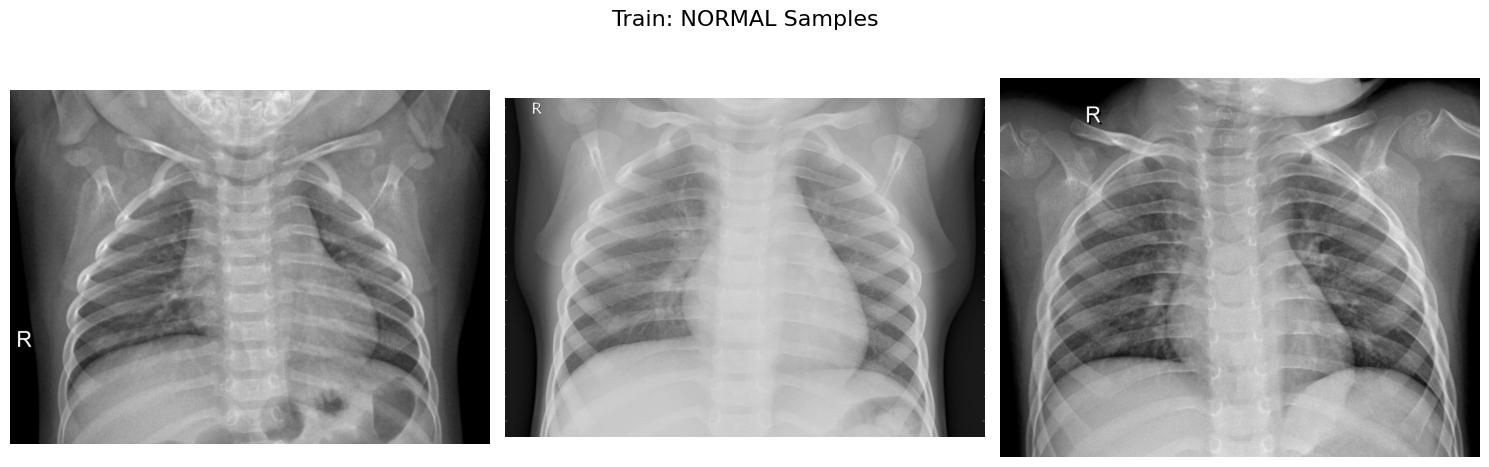

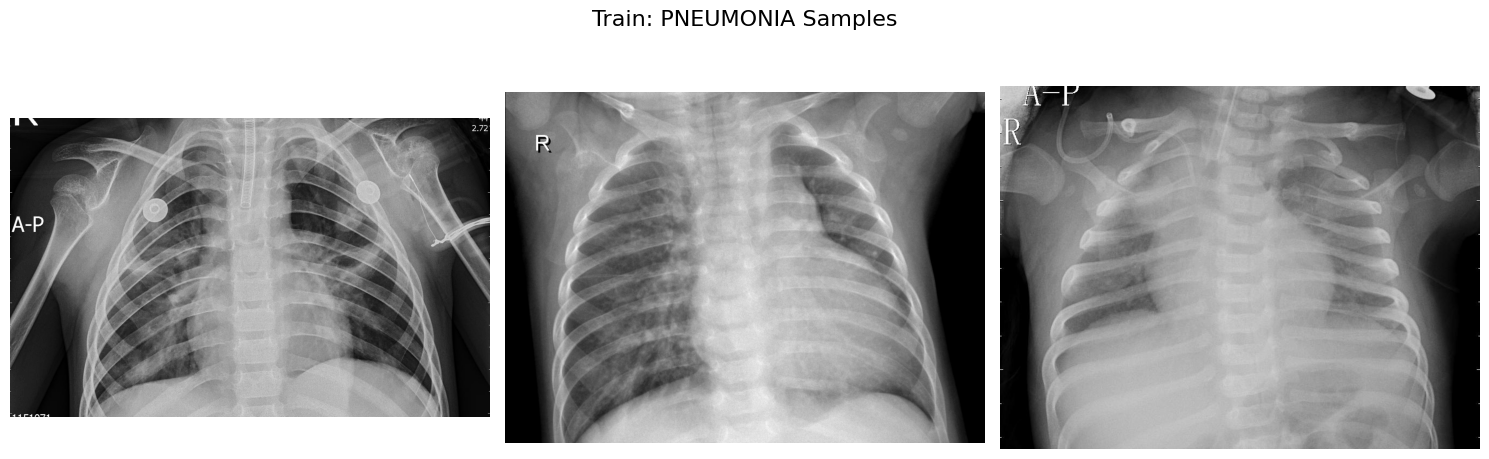

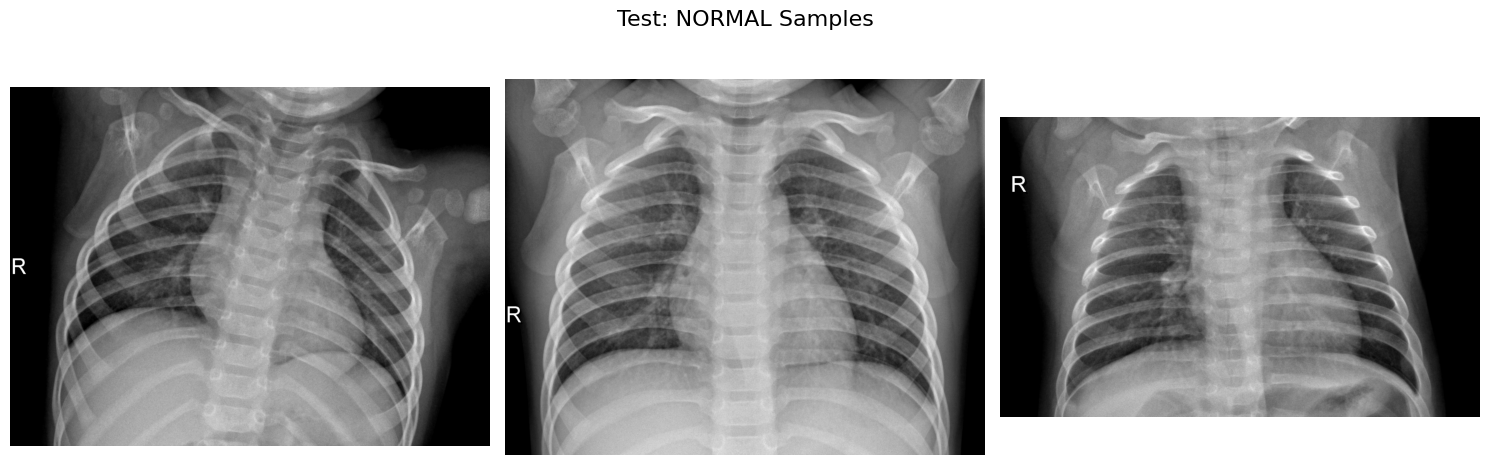

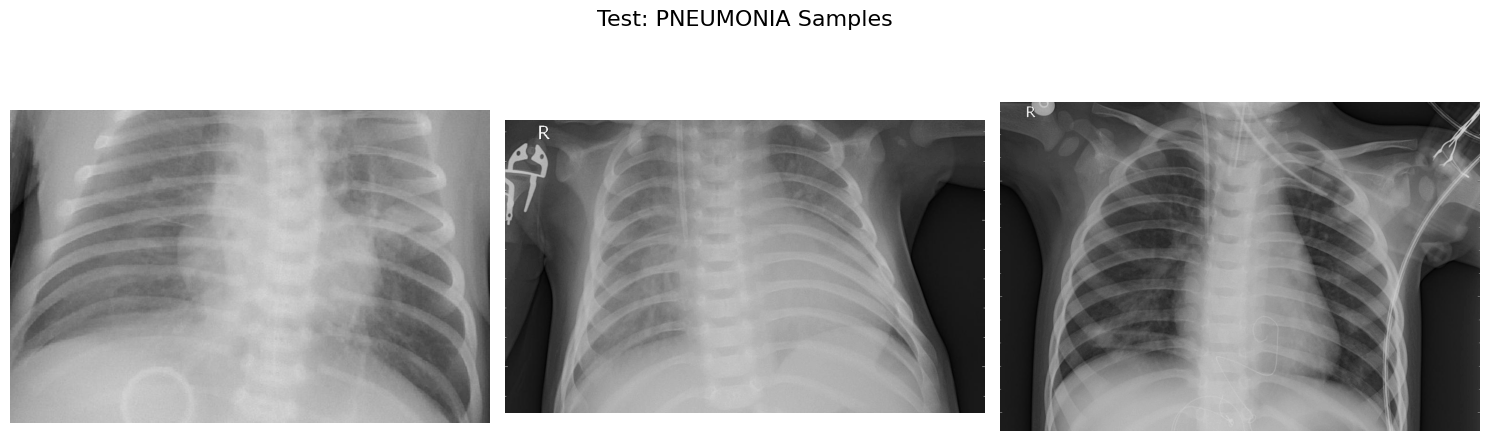

In [ ]:
# Function to get image file paths from a specific class
def get_sample_images(directory, class_name, num_samples=3):
    class_dir = os.path.join(directory, class_name)
    image_files = os.listdir(class_dir)
    sample_files = image_files[:num_samples]  # Take the first few images
    return [os.path.join(class_dir, file) for file in sample_files]

# Getting samples from train and test datasets
train_normal_samples = get_sample_images(train_new_dir, 'NORMAL', 3)
train_pneumonia_samples = get_sample_images(train_new_dir, 'PNEUMONIA', 3)
test_normal_samples = get_sample_images(test_new_dir, 'NORMAL', 3)
test_pneumonia_samples = get_sample_images(test_new_dir, 'PNEUMONIA', 3)


# Function to display images
def display_images(image_paths, title, rows=1, cols=3):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Displaying samples
display_images(train_normal_samples, "Train: NORMAL Samples")
display_images(train_pneumonia_samples, "Train: PNEUMONIA Samples")
display_images(test_normal_samples, "Test: NORMAL Samples")
display_images(test_pneumonia_samples, "Test: PNEUMONIA Samples")

#### <b> 4.3. Data Agumentation 

Showing multiple batches of augmented images...

Batch 1:


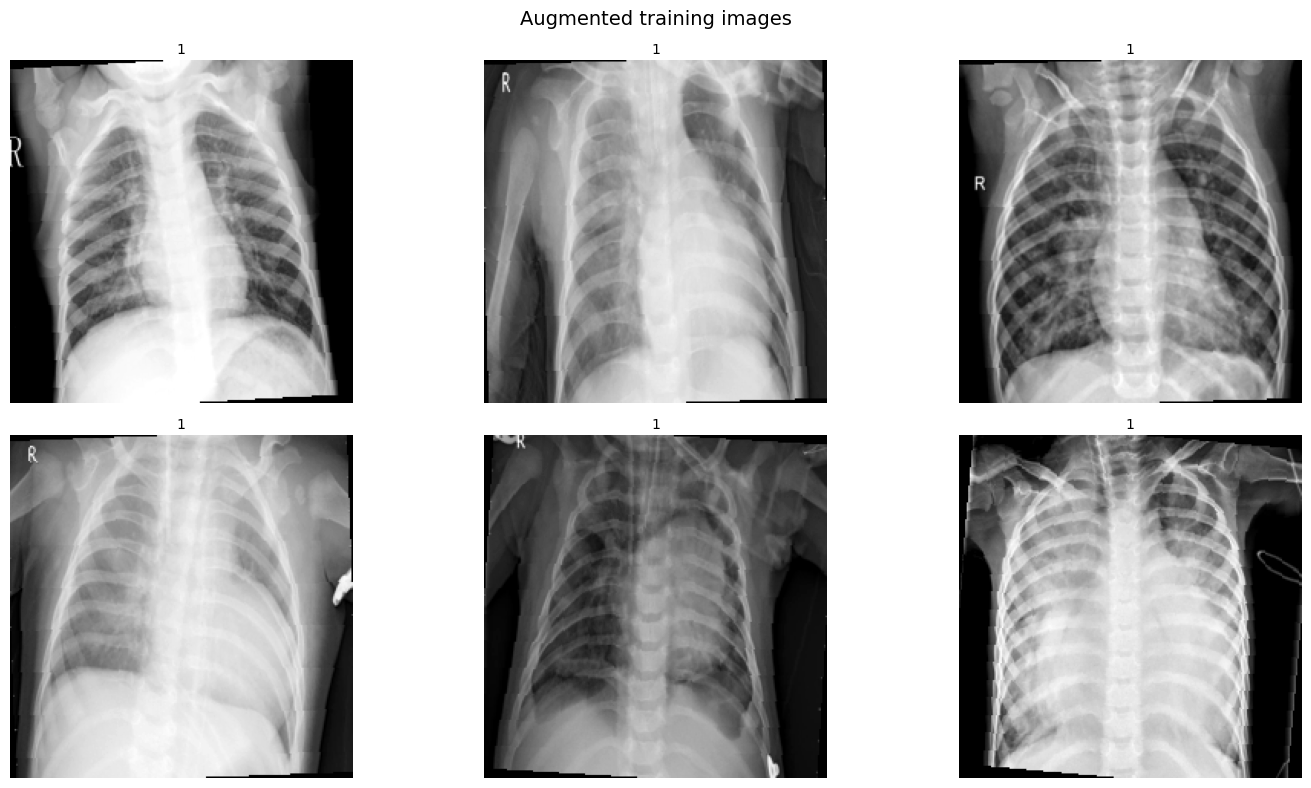


Batch 2:


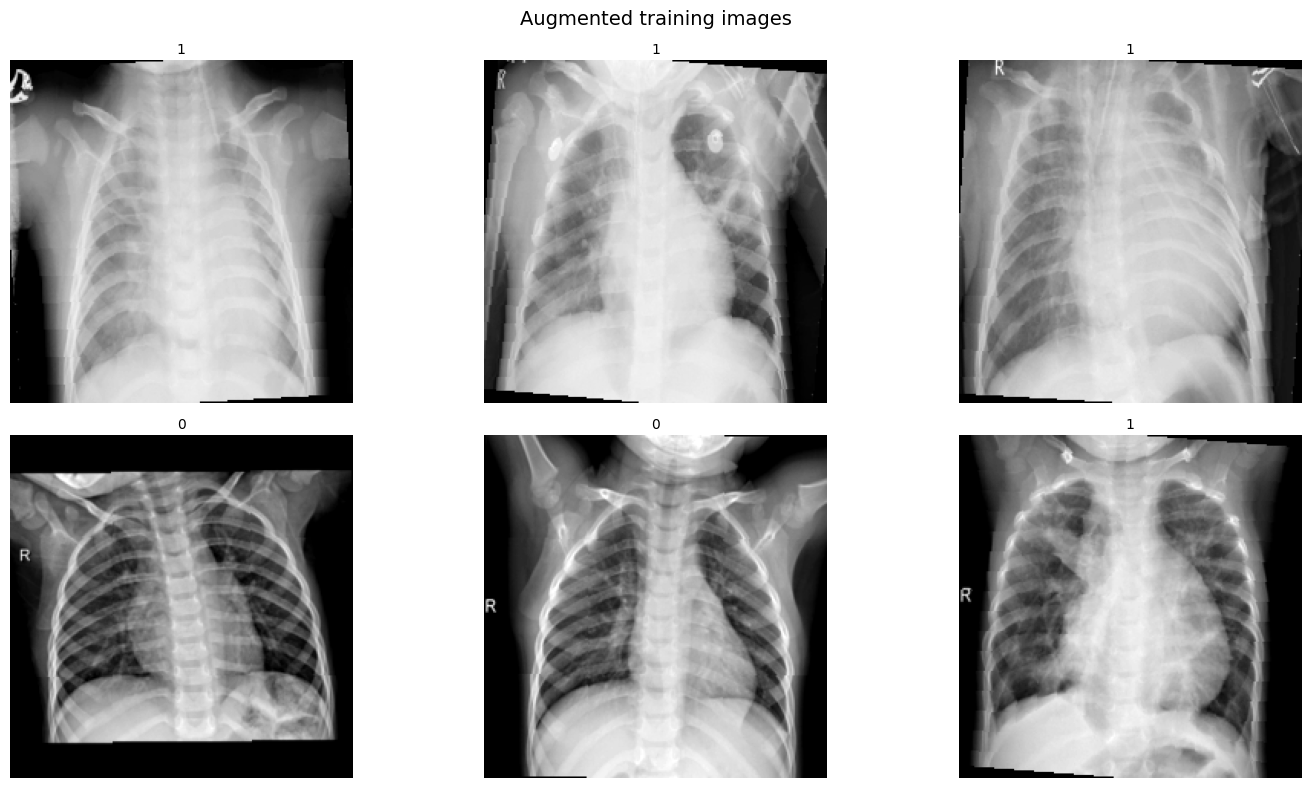


Batch 3:


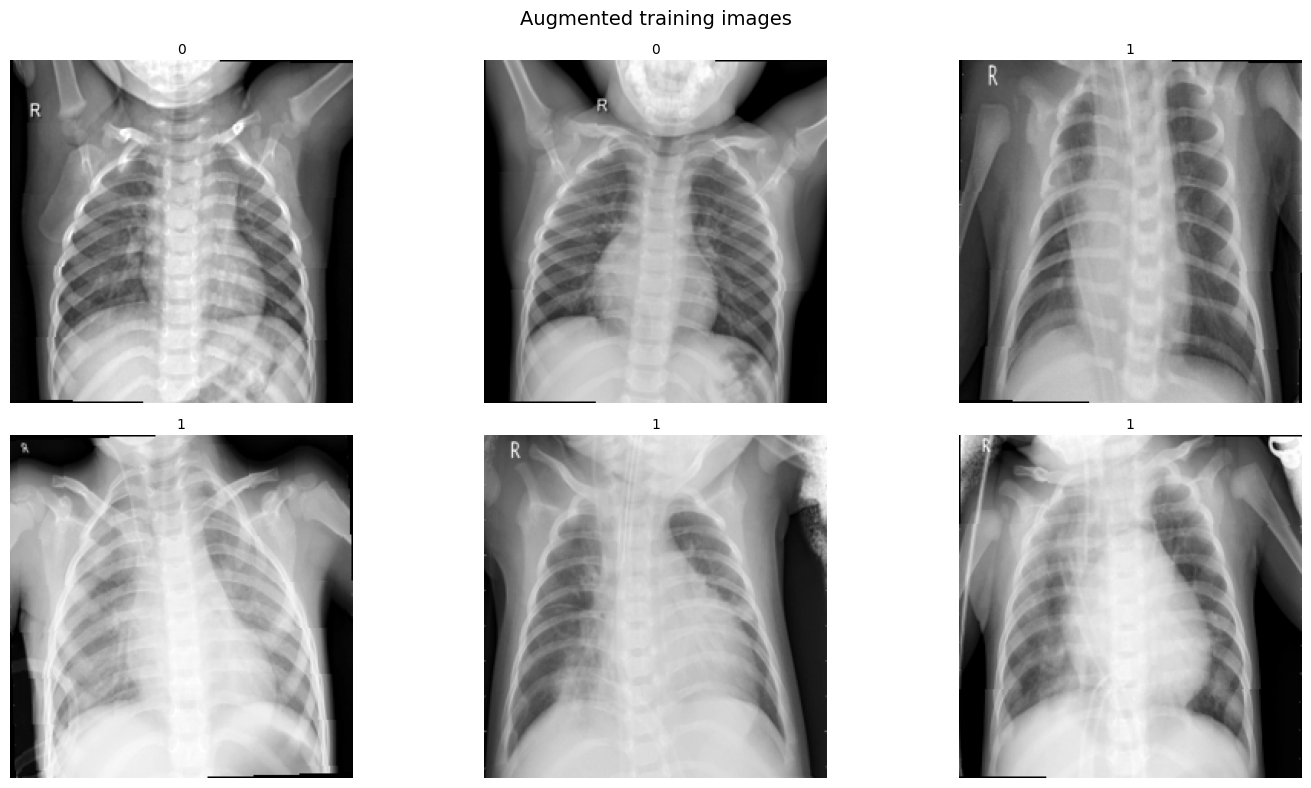

In [ ]:
# Function to display a grid of augmented images with their labels
def display_augmented_images(data_loader, class_names, num_images=6):
    # Getting a batch of images
    images, labels = next(iter(data_loader))
    # Creating a figure
    fig = plt.figure(figsize=(15, 8))
    rows = 2
    cols = 3

    for i in range(min(num_images, len(images))):
        plt.subplot(rows, cols, i + 1)
        # Getting image
        img = images[i]
        # Handling normalization (assuming mean=[0.485] and std=[0.229])
        img = img * 0.229 + 0.485
        img = torch.clamp(img, 0, 1)
        # Converting to numpy and handle channel dimension
        img = img.numpy().transpose(1, 2, 0)
        # If grayscale (1 channel), squeeze the color dimension
        if img.shape[2] == 1:
            img = img.squeeze()
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        # Getting label
        label = labels[i]
        # Adding title with label
        plt.title(f'{label}',
                 fontsize=10,
                 pad=5)
        plt.axis('off')

    plt.suptitle('Augmented training images',
                 fontsize=14,
                 y=0.98)
    plt.tight_layout()
    plt.show()

# Function to show multiple batches of augmented images to show different augmentations
def show_multiple_augmented_batches(data_loader, class_names, num_batches=3):
    print("Showing multiple batches of augmented images...")
    for i in range(num_batches):
        print(f"\nBatch {i+1}:")
        display_augmented_images(data_loader, class_names, num_images=6)

# Displaying augmented images
class_names = ["NORMAL", "PNEUMONIA"]
show_multiple_augmented_batches(train_loader, class_names, num_batches=3)

## 5. Modeling

## <b> 5.1. Custom CNN architecture with enhancements

## Custom CNN architecture with enhancements:
- Larger initial kernel (7x7) for better feature capture
- Residual connections for better gradient flow
- Batch normalization after each conv layer
- Global average pooling instead of flatten
- Proper weight initialization
- Dropout in both conv and fc layers


## Training enhancements:
- AdamW optimizer with weight decay
- Learning rate scheduler
- Inplace ReLU operations for memory efficiency
- Kaiming initialization for better convergence
- Global average pooling reduces parameters
- Proper channel progression
- Efficient residual blocks

## <b> 5.1.1 EnhancedCNN Model

In [ ]:
# Defining an enhanced CNN architecture
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(EnhancedCNN, self).__init__()

        # Initial large kernel for better feature capture in medical images
        self.initial = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            #nn.ReLU(inplace=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Residual blocks
        self.layer1 = self._make_residual_block(32, 64)
        self.layer2 = self._make_residual_block(64, 128)
        self.layer3 = self._make_residual_block(128, 256)

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers with dropout
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            #nn.ReLU(inplace=True),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _make_residual_block(self, in_channels, out_channels):
        return nn.Sequential(
            # First conv layer
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            #nn.ReLU(inplace=True),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            # Second conv layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),

            # Skip connection
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=1)
                if in_channels != out_channels else nn.Identity()
            ),
            #nn.ReLU(inplace=True),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
# Training setup
def setup_training(model, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True
    )

    return criterion, optimizer, scheduler

# Defining model
enhanced_cnn_model = EnhancedCNN().to(device)
criterion, optimizer, scheduler = setup_training(enhanced_cnn_model)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### <b> 5.1.2 Training Loop

In [ ]:
# Training function with history tracking
def train_model_with_history(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,  # Added scheduler parameter
    num_epochs=10,
    early_stopping_patience=5
):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early stopping setup
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Updating progress bar
            train_pbar.set_postfix({
                'loss': loss.item(),
                'acc': 100 * correct / total
            })

        # Calculating training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': loss.item(),
                    'acc': 100 * val_correct / val_total
                })

        # Calculating validation metrics
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step(val_loss)  # For ReduceLROnPlateau

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Print epoch results
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if early_stopping_counter >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    # Loading best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }


#### <b> 5.1.3 Training

In [ ]:
# Training the Enhanced CNN Model
print("Training Enhanced CNN Model...")
history = train_model_with_history(
    model=enhanced_cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,  # Passing the scheduler
    num_epochs=10,
    early_stopping_patience=5
)


Training Enhanced CNN Model...


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s, loss=0.0921, acc=89.9]



Epoch [1/10]
Train Loss: 0.3968, Train Acc: 81.82%
Val Loss: 0.2516, Val Acc: 89.86%
Learning Rate: 0.001000


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s, loss=0.66, acc=73.1]



Epoch [2/10]
Train Loss: 0.2931, Train Acc: 87.53%
Val Loss: 0.5937, Val Acc: 73.12%
Learning Rate: 0.001000


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s, loss=0.169, acc=92.8]



Epoch [3/10]
Train Loss: 0.2462, Train Acc: 90.24%
Val Loss: 0.1756, Val Acc: 92.82%
Learning Rate: 0.001000


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s, loss=0.129, acc=93.5]



Epoch [4/10]
Train Loss: 0.2248, Train Acc: 90.75%
Val Loss: 0.1528, Val Acc: 93.51%
Learning Rate: 0.001000


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s, loss=0.00385, acc=93.8]



Epoch [5/10]
Train Loss: 0.2037, Train Acc: 92.17%
Val Loss: 0.1986, Val Acc: 93.85%
Learning Rate: 0.001000


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s, loss=0.0213, acc=95]



Epoch [6/10]
Train Loss: 0.1960, Train Acc: 92.75%
Val Loss: 0.1305, Val Acc: 94.99%
Learning Rate: 0.001000


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s, loss=0.0678, acc=95.9]



Epoch [7/10]
Train Loss: 0.1719, Train Acc: 93.00%
Val Loss: 0.1097, Val Acc: 95.90%
Learning Rate: 0.001000


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s, loss=0.0512, acc=95.1]



Epoch [8/10]
Train Loss: 0.1719, Train Acc: 93.05%
Val Loss: 0.1261, Val Acc: 95.10%
Learning Rate: 0.001000


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s, loss=0.0473, acc=95.8]



Epoch [9/10]
Train Loss: 0.1553, Train Acc: 94.07%
Val Loss: 0.1104, Val Acc: 95.79%
Learning Rate: 0.001000


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s, loss=0.111, acc=96.5]


Epoch [10/10]
Train Loss: 0.1481, Train Acc: 94.17%
Val Loss: 0.1157, Val Acc: 96.47%
Learning Rate: 0.001000


#### <b> 5.1.4 Plotting Training History

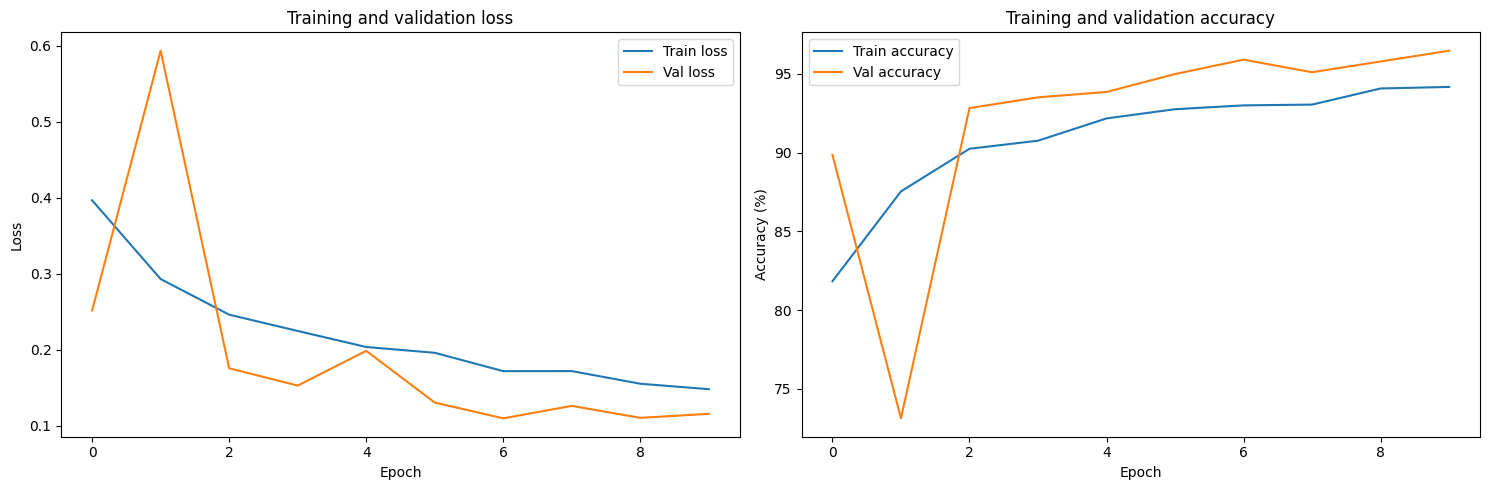

In [ ]:
# Plotting training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting losses
    ax1.plot(history['train_losses'], label='Train loss')
    ax1.plot(history['val_losses'], label='Val loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plotting accuracies
    ax2.plot(history['train_accuracies'], label='Train accuracy')
    ax2.plot(history['val_accuracies'], label='Val accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

#### <b> 5.1.5 Preparing Test Dataset and dataloader

In [ ]:
# Dataset and DataLoader for Test set

# Test transforms matching validation transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Converting to grayscale (1 channel)
    transforms.Grayscale(),
    transforms.ToTensor(),
    # Same normalization as val
    transforms.Normalize(mean=[0.485], std=[0.229])
])

test_dataset = ImageDataset(test_redis_df, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### <b> 5.1.6 Loading the Model for Inference

In [ ]:
# Function to evaluate the model and return predictions, true labels, and scores
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

#### <b> 5.1.7 Plot Confusion Matrix with Percentages

In [ ]:
# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(cm, model_name):
    plt.figure(figsize=(5, 5))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Annotation with both raw numbers and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.title(f"Confusion matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#### <b> 5.1.8 Evaluating the accuracy of Enhanced CNN Model

In [ ]:
# Evaluate Enhanced CNN on Test Set
y_true_cnn, y_pred_cnn = evaluate_model(enhanced_cnn_model, test_loader)

# Print accuracy for both models
accuracy_cnn = accuracy_score(y_true_cnn, y_pred_cnn)

print(f"Accuracy of enhanced CNN: {accuracy_cnn:.4f}")

Accuracy of enhanced CNN: 0.9431


#### <b> 5.1.9 Confusion Matrix of Enhanced CNN Model

Enhanced CNN:


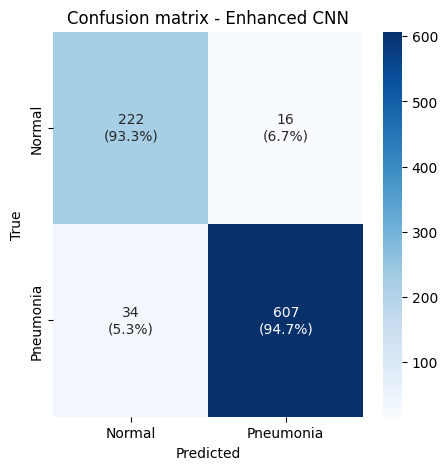

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       238
           1       0.97      0.95      0.96       641

    accuracy                           0.94       879
   macro avg       0.92      0.94      0.93       879
weighted avg       0.95      0.94      0.94       879



In [ ]:
# Scores and Confusion Matrix for enhanced CNN
print("Enhanced CNN:")
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plot_confusion_matrix_with_percentages(cm_cnn, "Enhanced CNN")
print("Classification Report:\n", classification_report(y_true_cnn, y_pred_cnn))

#### <b> 5.1.10 Saving the Final Best Model

In [ ]:
# Saving the model object
torch.save(enhanced_cnn_model.state_dict(), 'CNN_enhanced.pth')

#### <b> 5.1.11 Visualizing predictions from a trained model on test images

In [ ]:
# Recreating the model architecture for the model object
enhanced_cnn_model = EnhancedCNN()

# Path for weights file
enhanced_cnn_model_path = '/content/drive/MyDrive/MSDA Sem 3/Deep Learning/Project/Enhanced CNN, Resnet50 and ensemble code and weights/CNN_enhanced.pth'

# Loading the saved state dictionary
enhanced_cnn_model.load_state_dict(torch.load(enhanced_cnn_model_path))

# Moving to GPU if available
enhanced_cnn_model = enhanced_cnn_model.to(device)

# Setting to evaluation mode
enhanced_cnn_model.eval()

<ipython-input-17-d3343ee69b44>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enhanced_cnn_model.load_state_dict(torch.load(enhanced_cnn_model_path))


EnhancedCNN(
  (initial): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [ ]:
def show_balanced_predictions(model, loader, class_names, num_normal=10, num_pneumonia=10):
    """
    Display images with balanced true labels (Normal and Pneumonia).
    Highlight incorrect predictions in red.
    """
    model.eval()
    normal_images = []
    pneumonia_images = []

    # Defining denormalization function
    def denormalize(image):
        # Normalization was done with mean=[0.485] and std=[0.229]
        mean = torch.tensor([0.485]).view(-1, 1, 1)
        std = torch.tensor([0.229]).view(-1, 1, 1)
        return image * std + mean

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for i in range(images.size(0)):
                # Denormalizing image before converting to numpy
                image = denormalize(images[i].cpu())
                image = image.numpy().transpose(1, 2, 0)

                # Ensuring pixel values are in valid range [0, 1]
                image = np.clip(image, 0, 1)

                # Grayscale image
                if image.shape[-1] == 1:
                    image = image.squeeze(-1)

                true_label = labels[i].item()
                pred_label = predictions[i].item()
                label_dict = {
                    "image": image,
                    "true_label": class_names[true_label],
                    "pred_label": class_names[pred_label],
                    "correct": true_label == pred_label,
                }

                # Collecting images based on true labels
                if true_label == 0 and len(normal_images) < num_normal:
                    normal_images.append(label_dict)
                elif true_label == 1 and len(pneumonia_images) < num_pneumonia:
                    pneumonia_images.append(label_dict)

            # Breaking the loop if we have enough images
            if len(normal_images) >= num_normal and len(pneumonia_images) >= num_pneumonia:
                break

    # Combining images for display
    images_to_display = normal_images + pneumonia_images
    # Grid size
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_to_display):
            img_dict = images_to_display[idx]
            image = img_dict["image"]
            true_label = img_dict["true_label"]
            pred_label = img_dict["pred_label"]
            correct = img_dict["correct"]

            # Title with green for correct, red for incorrect
            title_color = "green" if correct else "red"
            ax.imshow(image, cmap="gray" if image.ndim == 2 else None, vmin=0, vmax=1)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
            ax.axis("off")
        else:
            # Empty cells
            ax.axis("off")

    plt.tight_layout()
    plt.show()

Balanced Predictions from enhanced CNN:


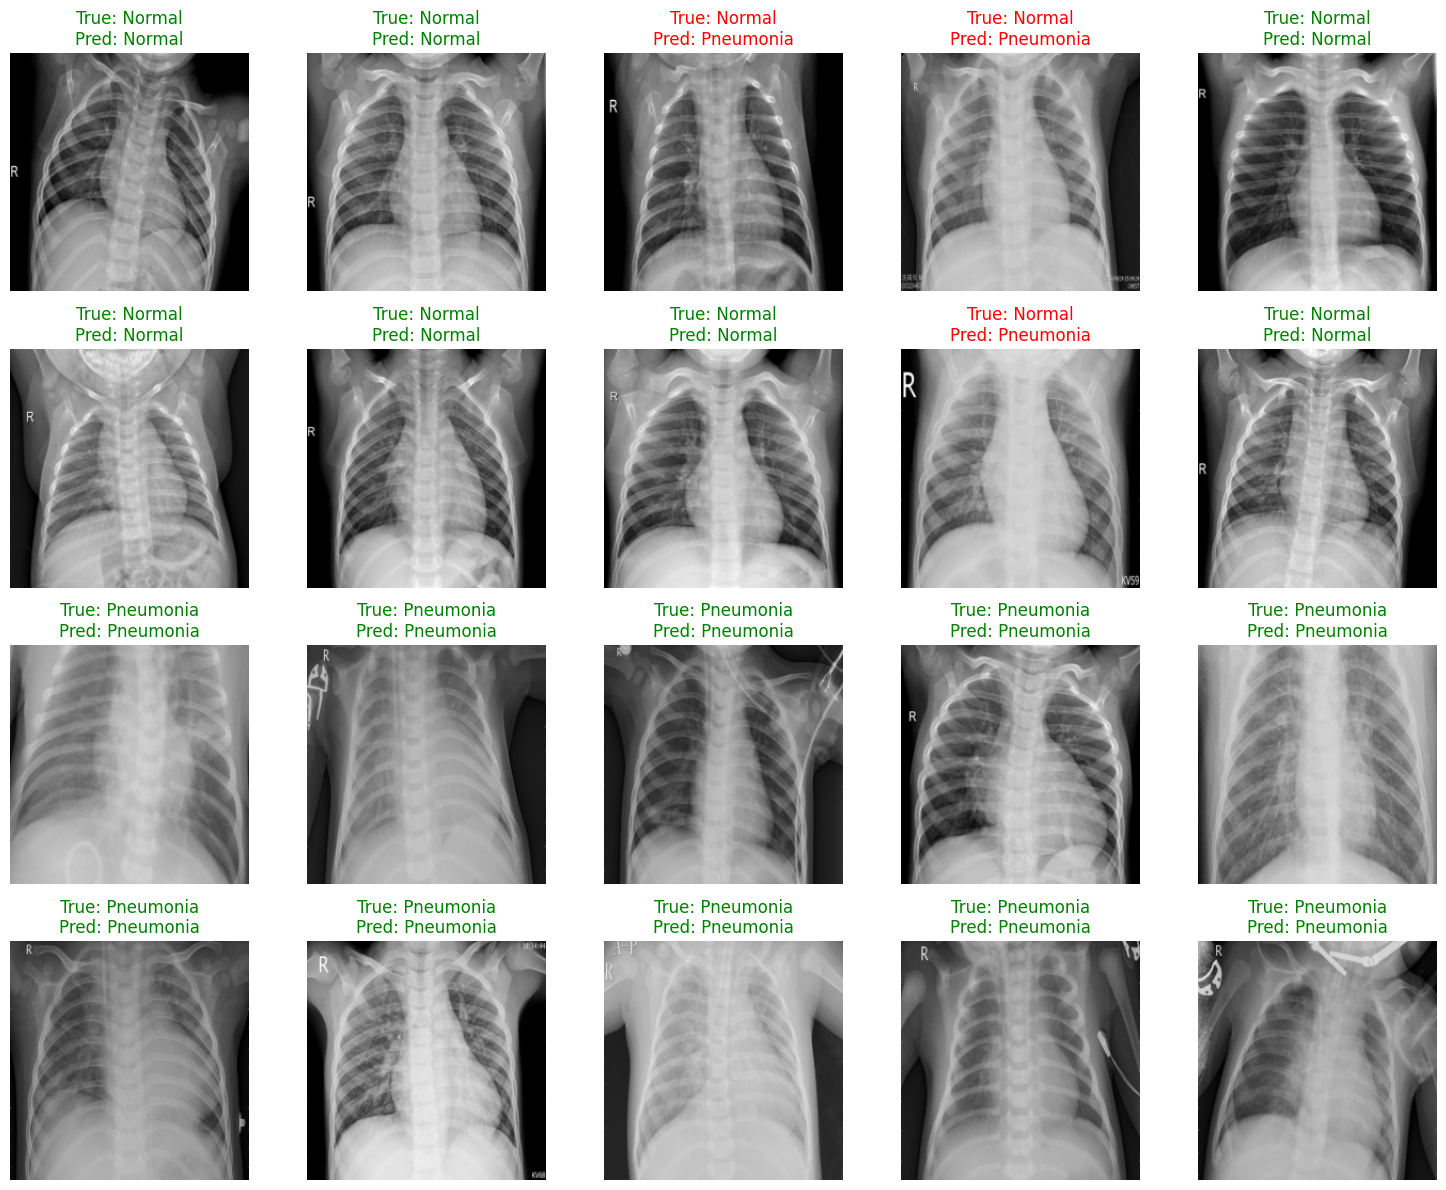

In [ ]:
# Show predictions for enhanced CNN
print("Balanced Predictions from enhanced CNN:")
show_balanced_predictions(enhanced_cnn_model, test_loader, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)

## <b> 5.2. Simple Resnet50

## Simple Resnet50 architecture:
- Deep architecture with 50 layers
- Uses skip connections (residual blocks) to solve vanishing gradient problem
- Initial 7x7 conv layer
- Max pooling
- 4 sets of residual blocks
- Average pooling
- Final fully connected layer
- Residual blocks let information skip layers via "shortcuts"
- Pre-trained on ImageNet, so already knows basic image features
- Final layer is modified for your specific task (i.e. 2 classes for pneumonia)

## <b> 5.2.1 Pretrained ResNet-50 model

In [ ]:
import torchvision.models as models
# ResNet50 with pretrained weights and grayscale input
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50Classifier, self).__init__()
        self.model = models.resnet50(pretrained=True)

        # Modifying first conv layer for grayscale input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modifying final fc layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

#### <b> 5.2.2 Creating and training the ResNet-50 model

In [ ]:
# Creating and training ResNet model
resnet_model = ResNet50Classifier().to(device)
criterion_res = nn.CrossEntropyLoss()
optimizer_res = optim.AdamW(resnet_model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler_res = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### <b> 5.2.3 Training

In [ ]:
# Training ResNet using same data loaders
history_resnet = train_model_with_history(
    resnet_model,
    train_loader,
    val_loader,
    criterion_res,
    optimizer_res,
    scheduler_res,
    num_epochs=10,
    early_stopping_patience=5
)

Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:21<00:00,  1.30it/s, loss=0.00743, acc=95.9]



Epoch [1/10]
Train Loss: 0.1870, Train Acc: 92.83%
Val Loss: 0.1257, Val Acc: 95.90%
Learning Rate: 0.000100


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:21<00:00,  1.31it/s, loss=0.0114, acc=96.9]



Epoch [2/10]
Train Loss: 0.1124, Train Acc: 96.34%
Val Loss: 0.0842, Val Acc: 96.92%
Learning Rate: 0.000100


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:21<00:00,  1.28it/s, loss=0.00381, acc=96.7]



Epoch [3/10]
Train Loss: 0.1084, Train Acc: 96.22%
Val Loss: 0.1114, Val Acc: 96.70%
Learning Rate: 0.000100


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:27<00:00,  1.02it/s, loss=0.000589, acc=97.6]



Epoch [4/10]
Train Loss: 0.0833, Train Acc: 97.49%
Val Loss: 0.0835, Val Acc: 97.61%
Learning Rate: 0.000100


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s, loss=0.00551, acc=97.3]



Epoch [5/10]
Train Loss: 0.0777, Train Acc: 97.22%
Val Loss: 0.0880, Val Acc: 97.27%
Learning Rate: 0.000100


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s, loss=0.00166, acc=97.6]



Epoch [6/10]
Train Loss: 0.0537, Train Acc: 98.15%
Val Loss: 0.0724, Val Acc: 97.61%
Learning Rate: 0.000100


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s, loss=0.000341, acc=98.1]



Epoch [7/10]
Train Loss: 0.0583, Train Acc: 98.19%
Val Loss: 0.0773, Val Acc: 98.06%
Learning Rate: 0.000100


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s, loss=0.062, acc=97.7]



Epoch [8/10]
Train Loss: 0.0300, Train Acc: 99.00%
Val Loss: 0.1023, Val Acc: 97.72%
Learning Rate: 0.000100


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:33<00:00,  1.21s/it, loss=0.0586, acc=97.4]



Epoch [9/10]
Train Loss: 0.0321, Train Acc: 99.07%
Val Loss: 0.1039, Val Acc: 97.38%
Learning Rate: 0.000100


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:23<00:00,  1.18it/s, loss=0.00292, acc=97.5]


Epoch [10/10]
Train Loss: 0.0302, Train Acc: 99.15%
Val Loss: 0.1039, Val Acc: 97.49%
Learning Rate: 0.000100


#### <b> 5.2.4 Evaluating the accuracy of Resnet50 Model

In [ ]:
# Evaluating Resnet50 on test set
y_true_resnet, y_pred_resnet = evaluate_model(resnet_model, test_loader)

# Printing accuracy for Resnet50
accuracy_resnet = accuracy_score(y_true_resnet, y_pred_resnet)

print(f"Accuracy of resnet50: {accuracy_resnet:.4f}")

Accuracy of resnet50: 0.9681


#### <b> 5.2.5 Confusion Matrix of Resnet50

Resnet50 model:


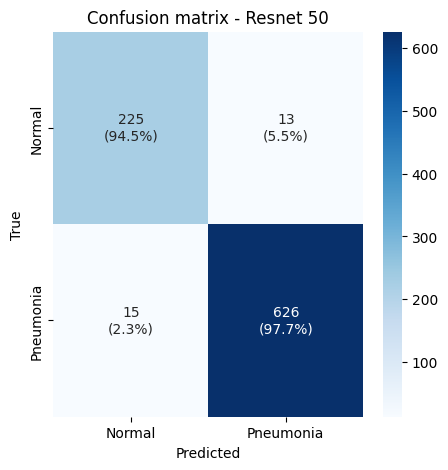

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       238
           1       0.98      0.98      0.98       641

    accuracy                           0.97       879
   macro avg       0.96      0.96      0.96       879
weighted avg       0.97      0.97      0.97       879



In [ ]:
# Scores and Confusion Matrix for Resnet50
print("Resnet50 model:")
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plot_confusion_matrix_with_percentages(cm_resnet, "Resnet 50")
print("Classification Report:\n", classification_report(y_true_resnet, y_pred_resnet))

#### <b> 5.2.6 Saving the Resnet50 Model

In [ ]:
# Saving the model object
torch.save(resnet_model.state_dict(), 'Resnet50_model.pth')

#### <b> 5.2.7 Visualizing predictions for the test images

In [ ]:
# Recreating the model architecture for the model object
resnet_model = ResNet50Classifier(num_classes=2)

# Path for weights file
resnetmodel_path = '/content/drive/MyDrive/MSDA Sem 3/Deep Learning/Project/Enhanced CNN, Resnet50 and ensemble code and weights/Resnet50_model.pth'

# Loading the saved state dictionary
resnet_model.load_state_dict(torch.load(resnetmodel_path))

# Moving to GPU if available
resnet_model = resnet_model.to(device)

# Setting to evaluation mode
resnet_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]
<ipython-input-20-20c99933fc6a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possi

ResNet50Classifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

Balanced Predictions from Resnet50:


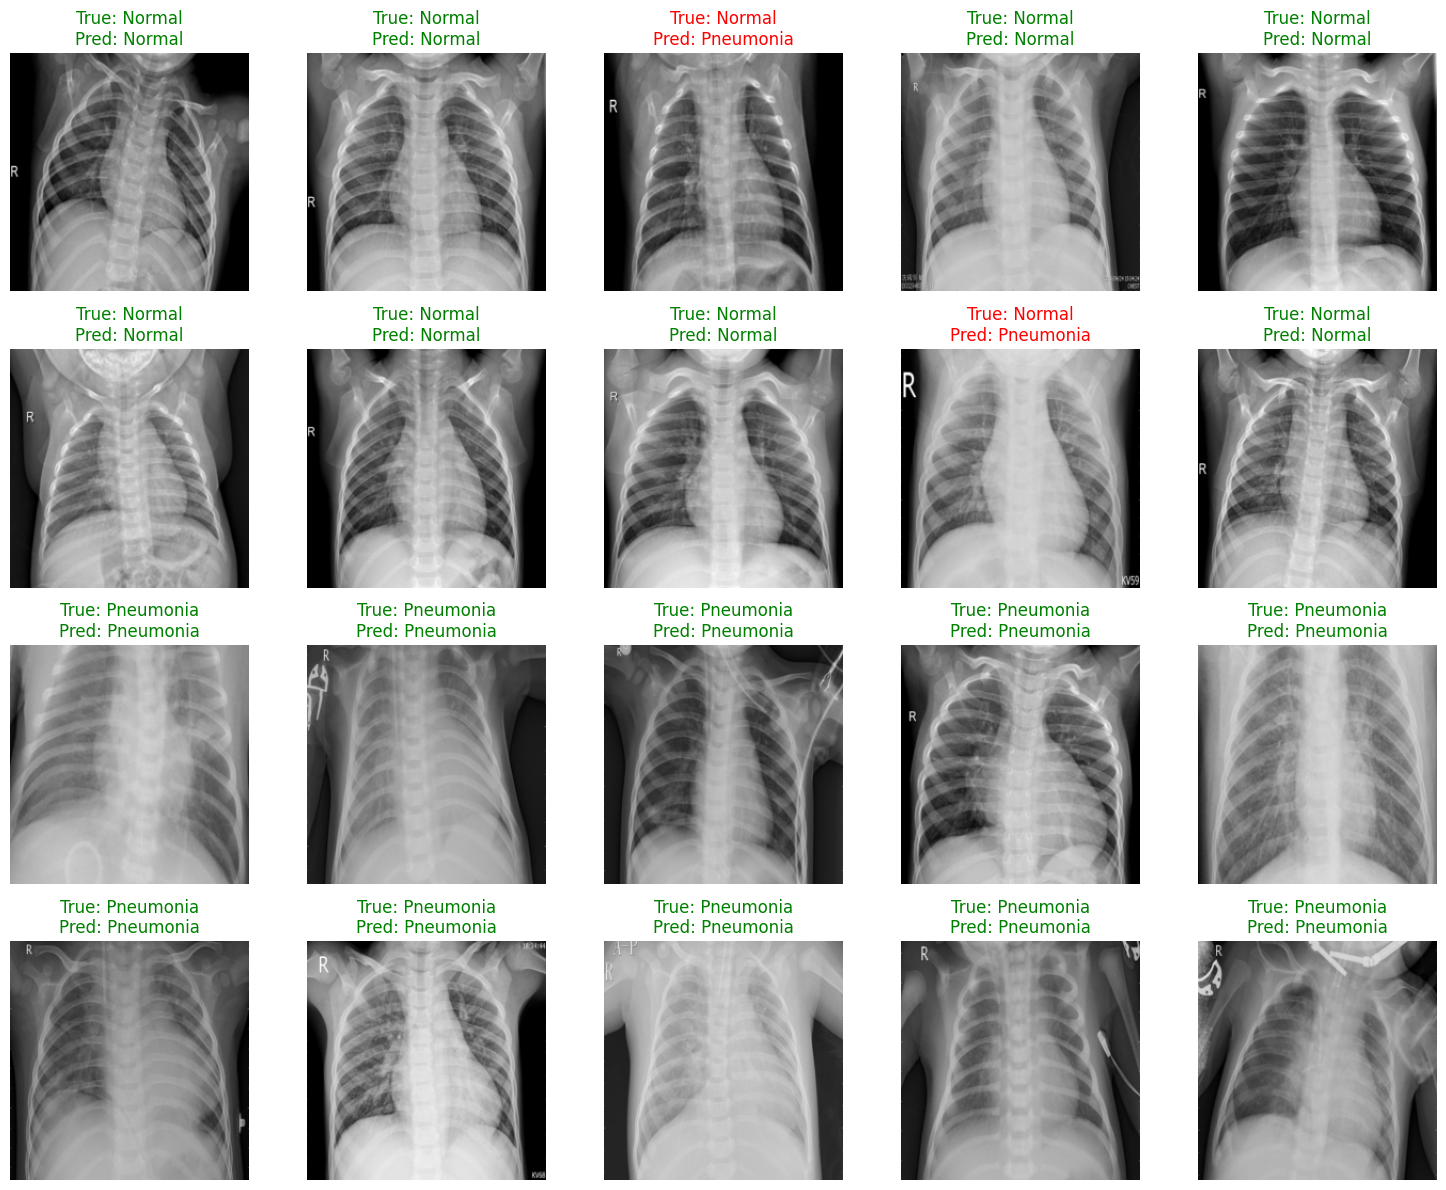

In [ ]:
# Show predictions for Resnet50
print("Balanced Predictions from Resnet50:")
show_balanced_predictions(resnet_model, test_loader, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)

## <b> 5.3. Ensembling multiple models 

## Ensembling:
- The following code uses weighted voting for ensemble predictions
- The ensemble typically performs better than individual models because it combines the strengths of both models i.e. CNN might be better at certain features while ResNet at others. It also reduces overfitting through model averaging

## Ensembling strategies:
- Majority voting
  - Each model votes for a class
  - Pick the class with most votes
  - Simple but effective
  - Example: If 3 models predict "Normal" and 2 predict "Pneumonia", prediction is "Normal"


- Average probabilities
  - Take average of probability scores from all models
  - Usually better than simple voting
  - Example: If models predict 60%, 70%, 80% for "Pneumonia", final prediction is 70%

- Weighted averaging
  - Give more weight to better-performing models
  - Better models get more "say" in final decision
  - Example: Best model gets 0.5 weight, others get 0.25 each

- Stacking
  - Use another model to learn how to combine predictions
  - More complex but can be more accurate
  - Example: Train a small neural network to combine other models' outputs


- Bagging (Bootstrap Aggregating)
  - Train same model type on different subsets of data
  - Combine their predictions
  - Good for reducing overfitting

## <b> 5.3.1 Defining Ensemble Model

#### <b> 5.3.2 Evaluates multiple models: Computes performance metrics

In [ ]:
import numpy as np
# Ensembling prediction function i.e. making ensemble predictions using multiple models
def ensemble_predict(models, loader, weights=None):
    if weights is None:
        weights = [1/len(models)] * len(models)

    all_predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Getting predictions from each model
            model_outputs = []
            for model in models:
                model.eval()
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1)
                model_outputs.append(probabilities)

            # Weighting and combining predictions
            weighted_outputs = torch.zeros_like(model_outputs[0])
            for output, weight in zip(model_outputs, weights):
                weighted_outputs += output * weight

            _, predicted = torch.max(weighted_outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(true_labels), np.array(all_predictions)

#### <b> 5.3.2 Evaluating Trained Models

In [ ]:
models = [enhanced_cnn_model, resnet_model]

In [ ]:
# Function to get accuracy-based weights
def get_performance_based_weights(models, val_loader):
    accuracies = []

    # Getting accuracy for each model on validation set
    for model in models:
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracies.append(correct/total)

    # Normalizing accuracies to sum to 1
    total_acc = sum(accuracies)
    weights = [acc/total_acc for acc in accuracies]

    return weights

# Using performance-based weights function to get the weights
performance_weights = get_performance_based_weights(models, val_loader)

In [ ]:
# Displaying the weights
print(f'Performance-based weight of Enhanced CNN model: {performance_weights[0]:.3f}')
print(f'Performance-based weight of Resnet50 model: {performance_weights[1]:.3f}')

Performance-based weight of Enhanced CNN model: 0.497
Performance-based weight of Resnet50 model: 0.503


#### <b> 5.3.3 Evaluates multiple models: Computes performance metrics

### From a performance standpoint, the weightage is almost equal with a slightly higher weightage for Resnet

In [ ]:
# Evaluating individual models and ensemble
def evaluate_all_models(models, loader, model_names):
    results = {}

    # Evaluating individual models
    for model, name in zip(models, model_names):
        y_true, y_pred = evaluate_model(model, loader)
        results[name] = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred)
        }

    # Evaluate ensemble
    y_true, y_pred = ensemble_predict(models, loader, weights=performance_weights)
    results['Ensemble'] = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

    return results

In [ ]:
# Using the models trained earlier
models = [enhanced_cnn_model, resnet_model]
model_names = ['Enhanced CNN', 'ResNet50']
results = evaluate_all_models(models, test_loader, model_names)

#### <b> 5.3.4 Displaying Evaluation Results

In [ ]:
# Printing results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Enhanced CNN Results:
accuracy: 0.9431
precision: 0.9743
recall: 0.9470
f1: 0.9604

ResNet50 Results:
accuracy: 0.9681
precision: 0.9797
recall: 0.9766
f1: 0.9781

Ensemble Results:
accuracy: 0.9670
precision: 0.9796
recall: 0.9750
f1: 0.9773


#### <b> 5.3.5 Visualizing Ensemble Predictions

In [ ]:
from torch.utils.data import TensorDataset
# Visualizing ensemble predictions - showing predictions from both individual models and ensemble
def show_ensemble_predictions(models, loader, class_names, num_images=10):
    models = [model.eval() for model in models]
    images_shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.cpu().numpy()

            # Getting predictions from each model and ensemble
            all_preds = []
            for model in models:
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds.cpu().numpy())

            # Getting ensemble predictions
            _, ensemble_preds = ensemble_predict(models, DataLoader(TensorDataset(images, torch.tensor(labels)), batch_size=len(images)))

            # Displaying results
            for i in range(len(images)):
                if images_shown >= num_images:
                    return

                # Creating subplot
                plt.figure(figsize=(12, 4))

                # Showing image
                plt.subplot(1, 3, 1)
                img = images[i].cpu().numpy().transpose(1, 2, 0)
                if img.shape[-1] == 1:
                    img = img.squeeze()
                plt.imshow(img, cmap='gray')
                plt.title(f'True: {class_names[labels[i]]}')
                plt.axis('off')

                # Showing predictions
                plt.subplot(1, 3, 2)
                plt.axis('off')
                plt.text(0.1, 0.8, f'CNN: {class_names[all_preds[0][i]]}',
                        color='green' if all_preds[0][i] == labels[i] else 'red')
                plt.text(0.1, 0.5, f'ResNet: {class_names[all_preds[1][i]]}',
                        color='green' if all_preds[1][i] == labels[i] else 'red')
                plt.text(0.1, 0.2, f'Ensemble: {class_names[ensemble_preds[i]]}',
                        color='green' if ensemble_preds[i] == labels[i] else 'red')

                plt.show()
                images_shown += 1

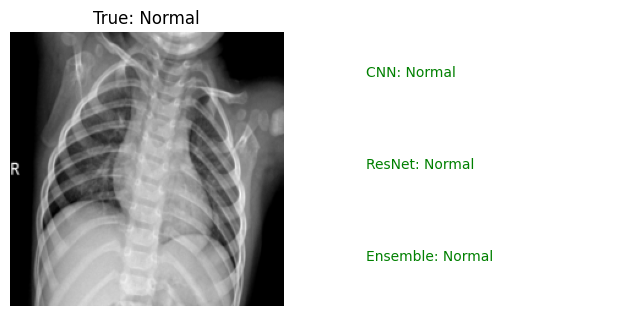

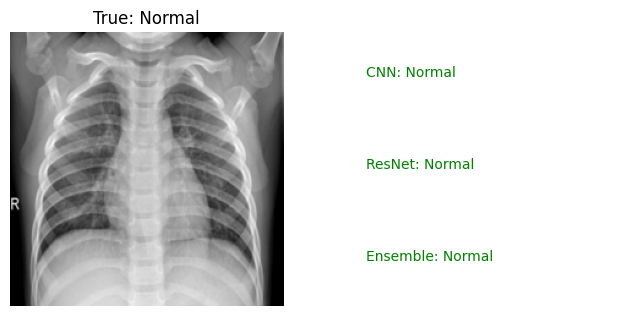

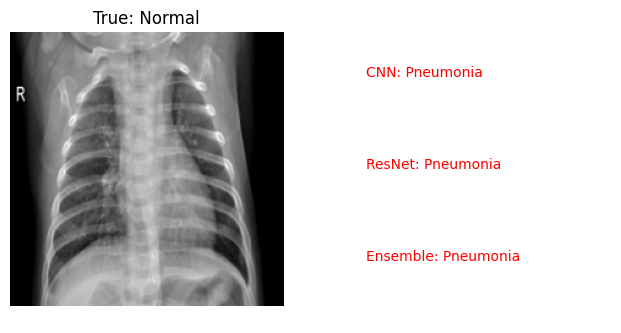

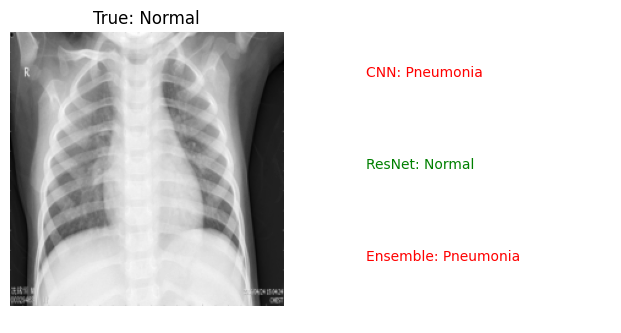

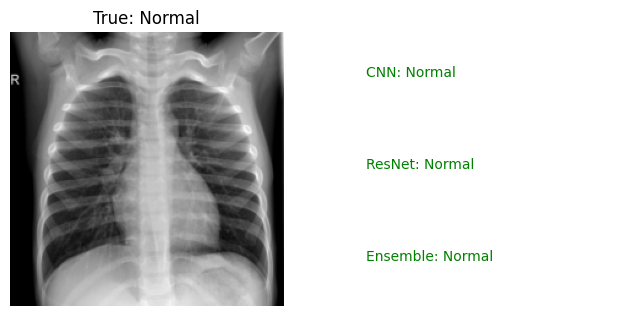

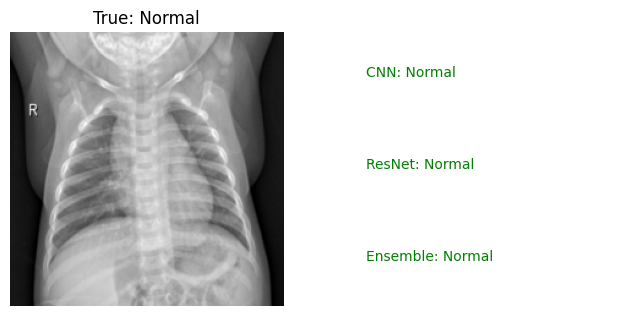

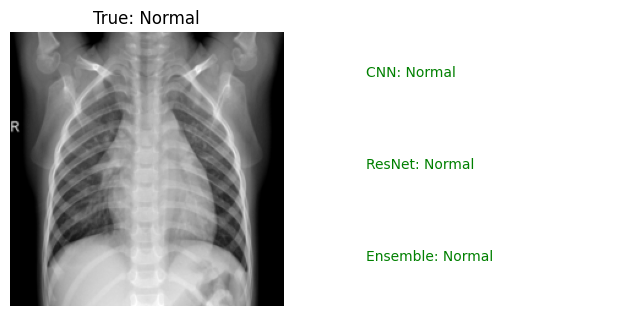

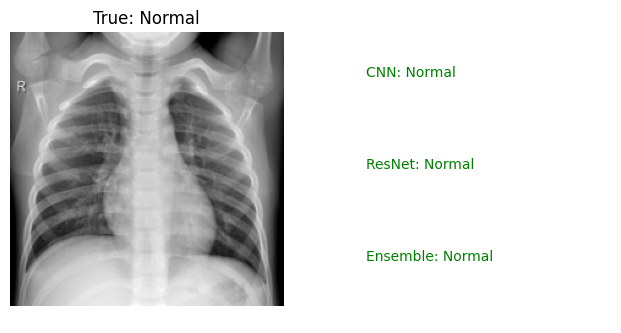

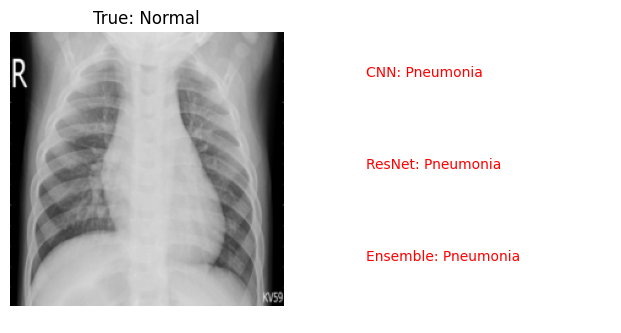

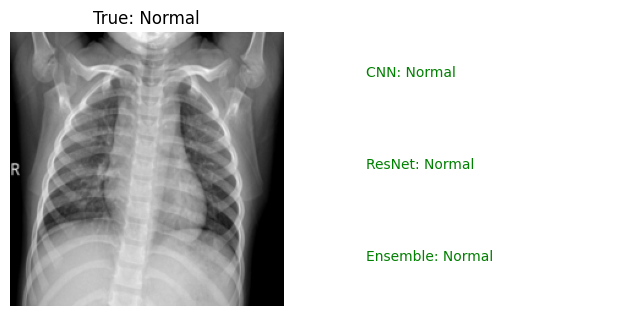

In [ ]:
# Showing some predictions comparing the individual and ensemble models
show_ensemble_predictions(
    models,
    test_loader,
    class_names=["Normal", "Pneumonia"],
    num_images=10
)

#### <b> 5.3.6 Saving and Loading an Ensemble Model

In [ ]:
'''
# Creating a dictionary with all necessary model components
ensemble_dict = {
    'enhanced_cnn_state': enhanced_cnn_model.state_dict(),
    'resnet_state': resnet_model.state_dict(),
    'class_names': ["Normal", "Pneumonia"],
    'ensemble_weights': [0.5, 0.5],  # if using weighted ensemble
    'model_architectures': {
        'enhanced_cnn': type(enhanced_cnn_model).__name__,
        'resnet': type(resnet_model).__name__
    }
}

# Saving the ensemble
save_path = 'pneumonia_ensemble_model.pth'
torch.save(ensemble_dict, save_path)

# To load and use the ensemble later:
def load_ensemble_model(model_path):
    # Loading the saved dictionary
    checkpoint = torch.load(model_path)

    # Recreating the models
    enhanced_cnn = EnhancedCNN()
    resnet = ResNet50Classifier()

    # Load the saved states
    enhanced_cnn.load_state_dict(checkpoint['enhanced_cnn_state'])
    resnet.load_state_dict(checkpoint['resnet_state'])

    # Move to GPU if available
    enhanced_cnn = enhanced_cnn.to(device)
    resnet = resnet.to(device)

    # Set to evaluation mode
    enhanced_cnn.eval()
    resnet.eval()

    return {
        'models': [enhanced_cnn, resnet],
        'weights': checkpoint['ensemble_weights'],
        'class_names': checkpoint['class_names']
    }

# Loading the ensemble
loaded_ensemble = load_ensemble_model('pneumonia_ensemble_model.pth')
models = loaded_ensemble['models']
weights = loaded_ensemble['weights']
class_names = loaded_ensemble['class_names']
'''

'\n# Creating a dictionary with all necessary model components\nensemble_dict = {\n    \'enhanced_cnn_state\': enhanced_cnn_model.state_dict(),\n    \'resnet_state\': resnet_model.state_dict(),\n    \'class_names\': ["Normal", "Pneumonia"],\n    \'ensemble_weights\': [0.5, 0.5],  # if using weighted ensemble\n    \'model_architectures\': {\n        \'enhanced_cnn\': type(enhanced_cnn_model).__name__,\n        \'resnet\': type(resnet_model).__name__\n    }\n}\n\n# Saving the ensemble\nsave_path = \'pneumonia_ensemble_model.pth\'\ntorch.save(ensemble_dict, save_path)\n\n# To load and use the ensemble later:\ndef load_ensemble_model(model_path):\n    # Loading the saved dictionary\n    checkpoint = torch.load(model_path)\n    \n    # Recreating the models\n    enhanced_cnn = EnhancedCNN()  \n    resnet = ResNet50Classifier()\n    \n    # Load the saved states\n    enhanced_cnn.load_state_dict(checkpoint[\'enhanced_cnn_state\'])\n    resnet.load_state_dict(checkpoint[\'resnet_state\'])\n  

Ensemble model:


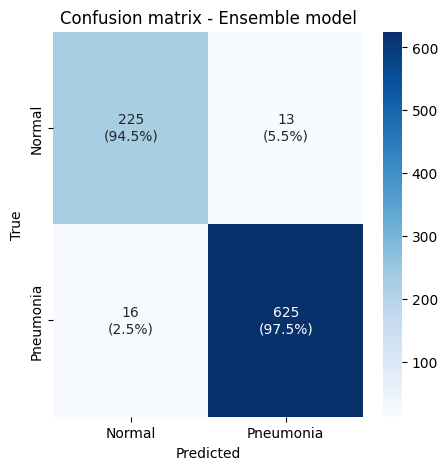

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       238
           1       0.98      0.98      0.98       641

    accuracy                           0.97       879
   macro avg       0.96      0.96      0.96       879
weighted avg       0.97      0.97      0.97       879



In [ ]:
# Scores and Confusion Matrix for ensemble model
print("Ensemble model:")
y_true_ens, y_pred_ens = ensemble_predict(models, test_loader, weights=performance_weights)
cm_ensemble = confusion_matrix(y_true_ens, y_pred_ens)
plot_confusion_matrix_with_percentages(cm_ensemble, "Ensemble model")
print("Classification Report:\n", classification_report(y_true_ens, y_pred_ens))

## 6. Plotting ROC Curves for Individual Models and Ensemble

In [ ]:
# Plotting ROC curves for all models and ensemble
def plot_roc_curves(models, test_loader):
   # Lists to store true labels and probabilities
   true_labels = []
   individual_probs = [[] for _ in models]
   ensemble_probs = []

   with torch.no_grad():
       for images, labels in test_loader:
           images, labels = images.to(device), labels.to(device)
           true_labels.extend(labels.cpu().numpy())

           # Getting probabilities from each model
           model_outputs = []
           for i, model in enumerate(models):
               model.eval()
               outputs = model(images)
               probs = torch.softmax(outputs, dim=1)
               # Storing probability of positive class (Pneumonia)
               individual_probs[i].extend(probs[:, 1].cpu().numpy())
               model_outputs.append(probs)

           # Ensemble probabilities
           ensemble_output = torch.mean(torch.stack(model_outputs), dim=0)
           ensemble_probs.extend(ensemble_output[:, 1].cpu().numpy())

   # Converting to numpy arrays
   true_labels = np.array(true_labels)
   individual_probs = [np.array(probs) for probs in individual_probs]
   ensemble_probs = np.array(ensemble_probs)

   # Plotting ROC curves
   plt.figure(figsize=(10, 8))

   # Colors for different models
   colors = ['blue', 'green', 'red']
   model_names = ['Enhanced CNN', 'ResNet', 'Ensemble']

   # Plotting for individual models
   for i, probs in enumerate(individual_probs):
       fpr, tpr, _ = roc_curve(true_labels, probs)
       roc_auc = auc(fpr, tpr)
       plt.plot(fpr, tpr, color=colors[i], lw=2,
               label=f'{model_names[i]} (AUC = {roc_auc:.3f})')

   # Plotting for ensemble
   fpr, tpr, _ = roc_curve(true_labels, ensemble_probs)
   roc_auc = auc(fpr, tpr)
   plt.plot(fpr, tpr, color=colors[2], lw=2,
            label=f'{model_names[2]} (AUC = {roc_auc:.3f})')

   # Plotting diagonal line (random classifier)
   plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

   # Customizing plot
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.05])
   plt.xlabel('False positive rate', fontsize=12)
   plt.ylabel('True positive rate', fontsize=12)
   plt.title('ROC curves for Pneumonia detection', fontsize=14)
   plt.legend(loc="lower right", fontsize=10)
   plt.grid(True, alpha=0.3)

   '''
   # Adding text box with AUC values
   textstr = '\n'.join([
       f'{model_names[i]}: AUC = {auc(roc_curve(true_labels, probs)[0], roc_curve(true_labels, probs)[1]):.3f}'
       for i, probs in enumerate(individual_probs + [ensemble_probs])
   ])
   props = dict(boxstyle='round', facecolor='white', alpha=0.8)
   plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
            fontsize=10, verticalalignment='top', bbox=props)
   '''

   plt.tight_layout()
   plt.show()

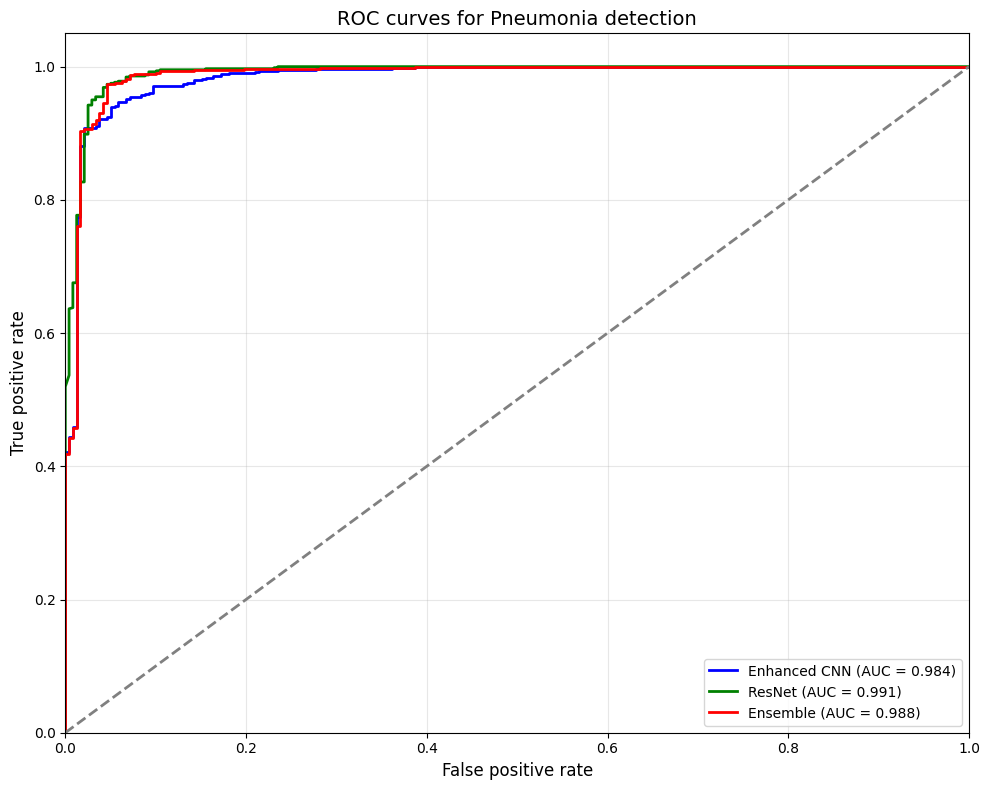

In [ ]:
# Running the function on the individual models and ensemble
models = [enhanced_cnn_model, resnet_model]
plot_roc_curves(models, test_loader)

## 7. Explaining Model Predictions with SHAP and LIME

## Explainable AI

- SHAP shows feature contributions (blue/red)
- LIME shows local interpretable explanations
- Each method gives slightly different insights and combined view helps validate model decisions

### SHAP (SHapley Additive exPlanations):
- Think of it like a "contribution calculator"
- Shows how much each part of the image contributes to the final decision
- Blue means "pushes towards negative class" (Normal)
- Red means "pushes towards positive class" (Pneumonia)
- Helps understand which regions influenced the prediction most
- Like having each pixel "vote" for or against a diagnosis

### LIME (Local Interpretable Model-agnostic Explanations):
- Works like "digital highlighter"
- Takes an image, divides it into parts
- Turns different parts on/off to see what affects the prediction
- Highlights the most important regions that led to the decision
- Like asking "which parts of the image would you need to keep to make the same diagnosis?"
- Simpler to understand than SHAP but less detailed

In [ ]:
#!pip install lime

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=398e4fe612e155ed46869211e34ddac60ba6be7429811f5cf459864595138d0b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Checking image shapes
for images, _ in test_loader:
    print("Batch shape:", images.shape)
    print("Single image shape:", images[0].shape)
    break

# Printing model architectures to check layers
print("\nEnhanced CNN architecture:")
print(enhanced_cnn_model)
print("\nResNet architecture:")
print(resnet_model)

Batch shape: torch.Size([32, 1, 224, 224])
Single image shape: torch.Size([1, 224, 224])

Enhanced CNN architecture:
EnhancedCNN(
  (initial): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Required imports
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import traceback

# Function to pick up two test samples: one Normal, one Pneumonia to create a 2x3 grid visualization
def explain_predictions(models, test_loader, class_names, num_samples=2):
   samples = []
   labels_found = set()

   # Getting samples - one of each class
   with torch.no_grad():
       for images, labels in test_loader:
           for img, label in zip(images, labels):
               if str(label) not in labels_found and len(samples) < num_samples:
                   samples.append((img, label))
                   labels_found.add(str(label))
               if len(samples) >= num_samples:
                   break
           if len(samples) >= num_samples:
               break

   # Creating the figure
   fig, axs = plt.subplots(len(samples), 3, figsize=(15, 5*len(samples)))
   if len(samples) == 1:
       axs = [axs]

   for idx, (img, label) in enumerate(samples):
       img = img.to(device)

       # Getting ensemble model prediction
       outputs = []
       for model in models:
           model.eval()
           output = model(img.unsqueeze(0))
           outputs.append(torch.softmax(output, dim=1))
       ensemble_output = torch.mean(torch.stack(outputs), dim=0)
       pred = torch.argmax(ensemble_output).item()

       # Original X-ray with true and predicted labels
       img_np = img.cpu().numpy().squeeze()
       axs[idx][0].imshow(img_np, cmap='gray')
       axs[idx][0].set_title(f'True: {"Normal" if int(label) == 0 else "Pneumonia"}\n'
                            f'Pred: {"Normal" if pred == 0 else "Pneumonia"}',
                            fontsize=12, pad=10)

       try:
           # SHAP
           # Setting background
           background = torch.zeros((5, 1, 224, 224)).to(device)
           e = shap.GradientExplainer(models[0], background)
           test_images = img.unsqueeze(0)
           shap_values = e.shap_values(test_images)

           if isinstance(shap_values, list):
               # Taking difference between classes and enhance contrast
               shap_img = shap_values[1][0, 0] - shap_values[0][0, 0]
               shap_img = np.abs(shap_img)
               p99 = np.percentile(shap_img, 99)
               shap_img = shap_img / (p99 + 1e-8)
               shap_img = np.clip(shap_img, -1, 1)
           else:
               shap_img = np.sum(shap_values, axis=-1)[0, 0]
               shap_img = np.clip(shap_img / np.percentile(np.abs(shap_img), 99), -1, 1)

           # Overlaying SHAP on original image
           img_rgb = np.stack([img_np] * 3, axis=-1)
           shap_overlay = np.zeros_like(img_rgb)
           # Red for positive, blue for negative influences
           shap_overlay[shap_img > 0] = [1, 0, 0]  # Red
           shap_overlay[shap_img < 0] = [0, 0, 1]  # Blue
           alpha = np.abs(shap_img)

           # Combining original and overlay
           combined = img_rgb * (1 - alpha)[..., np.newaxis] + shap_overlay * alpha[..., np.newaxis]

           im = axs[idx][1].imshow(combined)
           axs[idx][1].set_title('SHAP: Region influence\n'
                                 'Red: Contributing to Pneumonia\n'
                                 'Blue: Contributing to Normal',
                                fontsize=12, pad=10)

       except Exception as e:
           print(f"SHAP failed: {e}")
           traceback.print_exc()
           axs[idx][1].text(0.5, 0.5, 'SHAP Failed', ha='center')

       try:
           # LIME with improved visualization
           explainer = lime_image.LimeImageExplainer()
           img_for_lime = (img_np * 255).astype('uint8')
           img_for_lime = np.stack([img_for_lime] * 3, axis=-1)

           explanation = explainer.explain_instance(
               img_for_lime,
               lambda x: ensemble_predict(models, x),
               top_labels=2,
               hide_color=0,
               # Increased samples for better explanation
               num_samples=1000
           )

           # Getting explanation with both positive and negative contributions
           temp, mask = explanation.get_image_and_mask(
               explanation.top_labels[0],
               positive_only=False,
               # Increased for more comprehensive explanation
               num_features=15,
               hide_rest=False
           )

           # Creating colored visualization with yellow boundaries
           # Red for positive (supporting prediction)
           # Green for negative (opposing predictions)
           viz = mark_boundaries(temp / 255, mask, color=(1, 1, 0), mode='thick')
           axs[idx][2].imshow(viz)
           title = ('LIME: Region Analysis\n'
             'Yellow Outlines: Important Features\n'
             'Red Areas: Support Pneumonia\n'
             'Green Areas: Support Normal')
           axs[idx][2].set_title(title, fontsize=12, pad=10)

       except Exception as e:
           print(f"LIME failed: {e}")
           axs[idx][2].text(0.5, 0.5, 'LIME Failed', ha='center')

       # Turning off axes for all subplots
       for ax in axs[idx]:
           ax.axis('off')

   plt.tight_layout()
   plt.show()

# Helper function for ensemble predictions which returns averaged predictions from ensemble
def ensemble_predict(models, x):
   if isinstance(x, np.ndarray):
       if x.max() > 1.0:
           x = x / 255.0

       if x.ndim == 3 and x.shape[-1] == 3:
           x = np.mean(x, axis=-1)
       elif x.ndim == 4 and x.shape[-1] == 3:
           x = np.mean(x, axis=-1)

       if x.ndim == 2:
           x = x[np.newaxis, np.newaxis, ...]
       elif x.ndim == 3:
           x = x[:, np.newaxis, ...]

       x = torch.FloatTensor(x).to(device)

   predictions = []
   with torch.no_grad():
       for model in models:
           model.eval()
           output = model(x)
           pred = torch.softmax(output, dim=1)
           predictions.append(pred.cpu().numpy())

   return np.mean(predictions, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

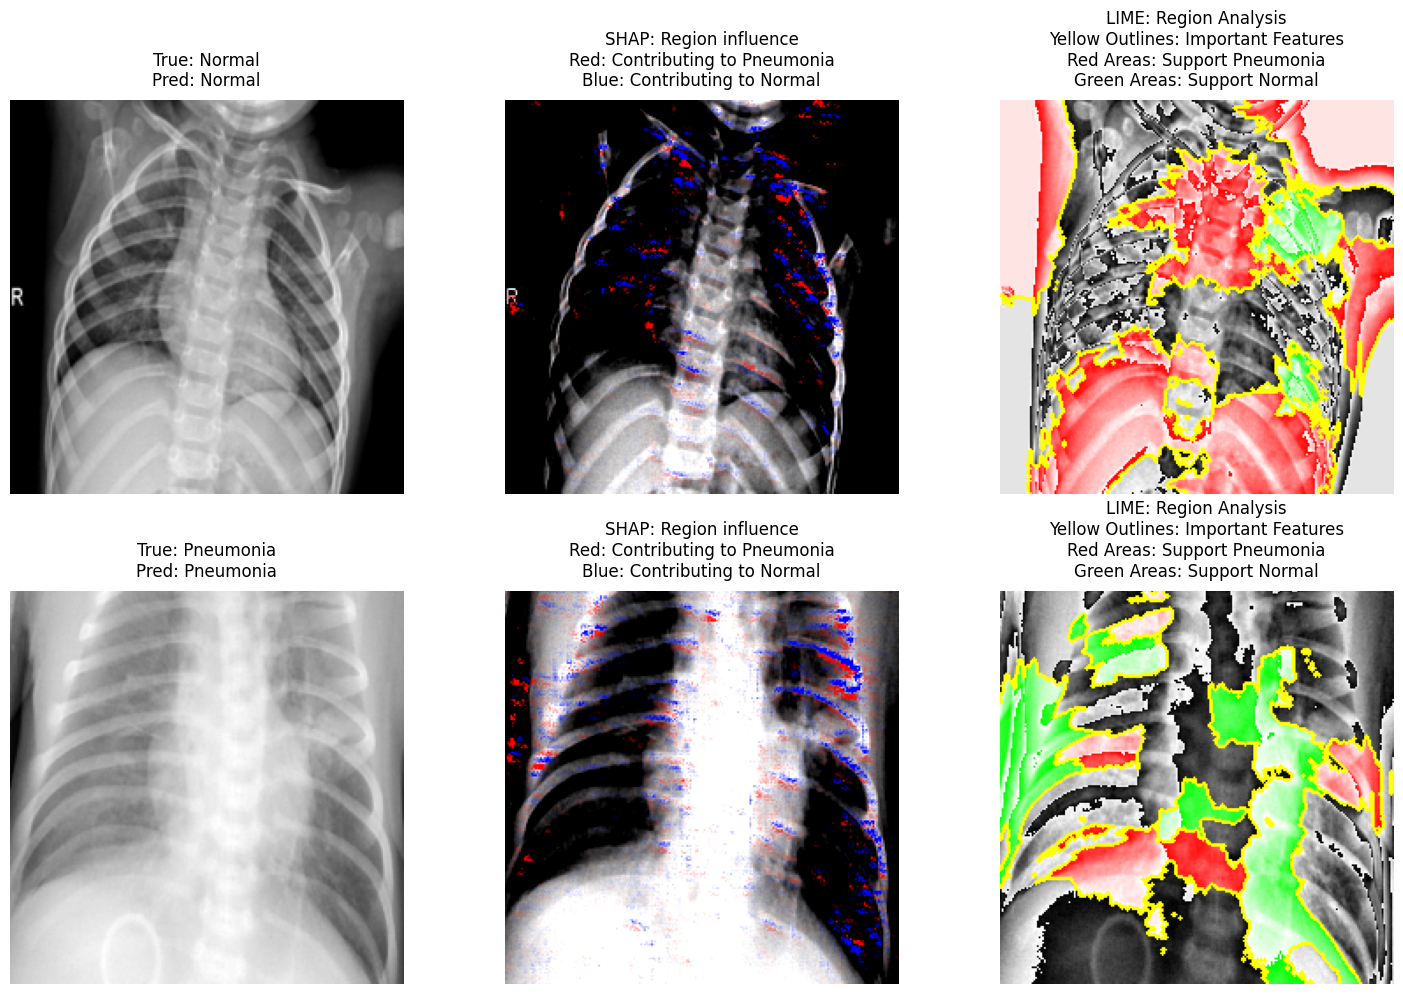

In [ ]:
# Running the functions on the trained models
models = [enhanced_cnn_model, resnet_model]
explain_predictions(models, test_loader, class_names=["Normal", "Pneumonia"])